## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# These are the 3D points of the reference/undistorted image. Z axis points are all 0 as the reference image
# is on a flat surface on z = 0. 6 by 9 internal points grid.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
#        cv2.waitKey(500)

cv2.destroyAllWindows()

### check size of all images (calibration and test images)

In [3]:
# Before computing camera calibration parameters, let's make sure dimensions of all images are same as the 
# cv2.calibrateCamera() API depends on the image shape being used. In the test below all images (camera calibration
#images and test images have same dimension (720, 1280, 3), except camera_cal/calibration7.jpg which is (721, 1281, 3) )
#Will not use calibration7.jpg in camera matrix and distortion parameter determination

# images = glob.glob('camera_cal/calibration*.jpg')
# print ("shape of chess board images")
# for img in images:
#     print (cv2.imread(img).shape, img)
# print ("shape of test images")
# images = glob.glob('test_images/test*.jpg')
# for img in images:
#     print (cv2.imread(img).shape)
# print ("shape of straight line test images")
# images = glob.glob('test_images/straight_lines*.jpg')
# for img in images:
#     print (cv2.imread(img).shape)

## Compute distortion coefficients given a set of chessboard images

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# TODO - check ret for success.
# mtx is the camera matrix which maps points from 3D space to 2D
# dist are the camera distortion parameters
print (mtx.shape, dist)

(3, 3) [[-0.24688833 -0.02372816 -0.00109843  0.00035105 -0.00259134]]


### Optional step to pickle/persistently save the camera matrix and distortion parameters

In [5]:
import pickle

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/camera_params.p", "wb" ) )

## Generate undistorted images

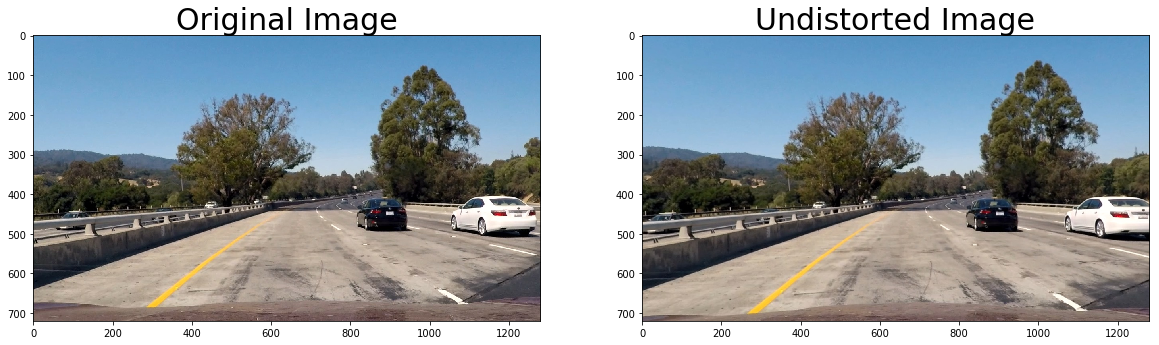

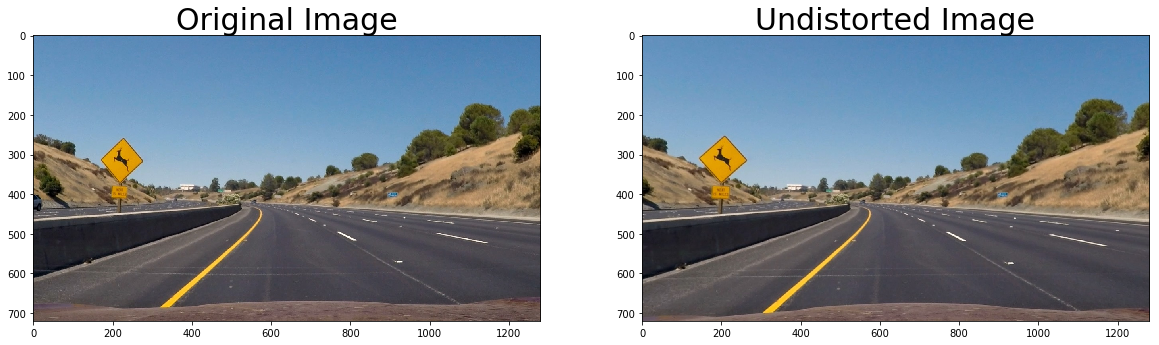

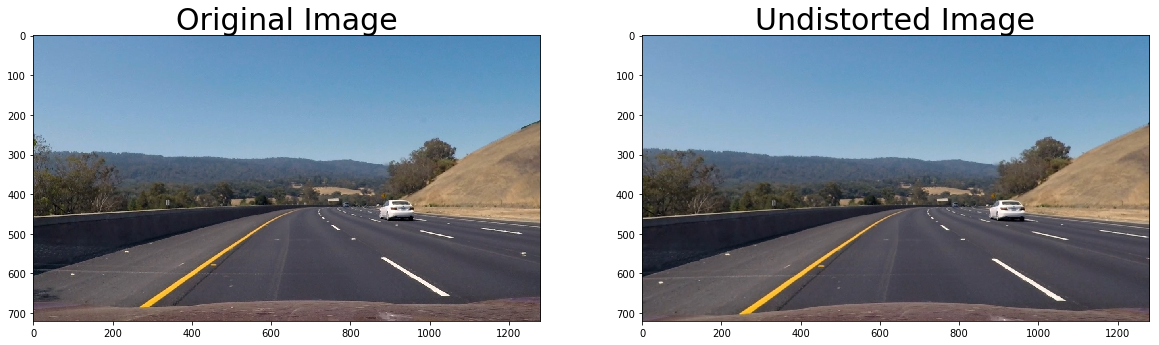

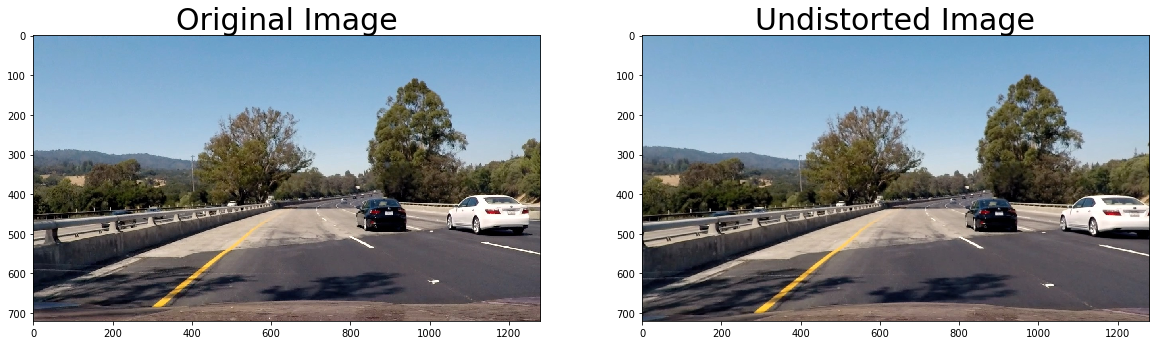

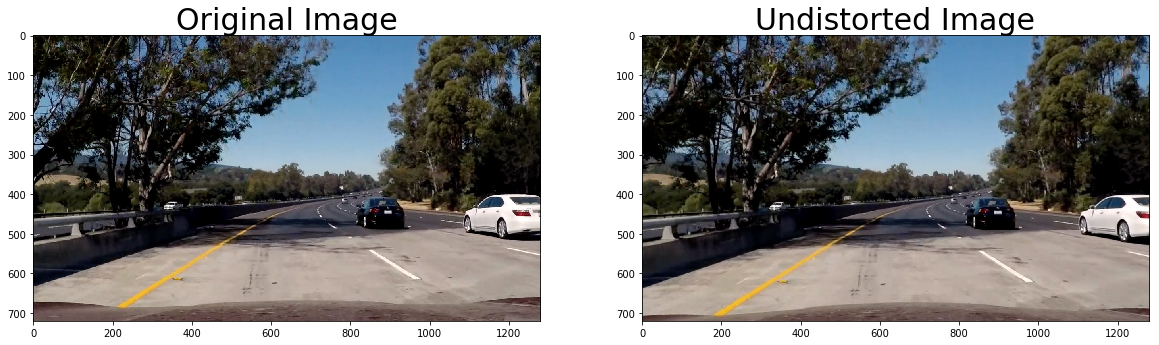

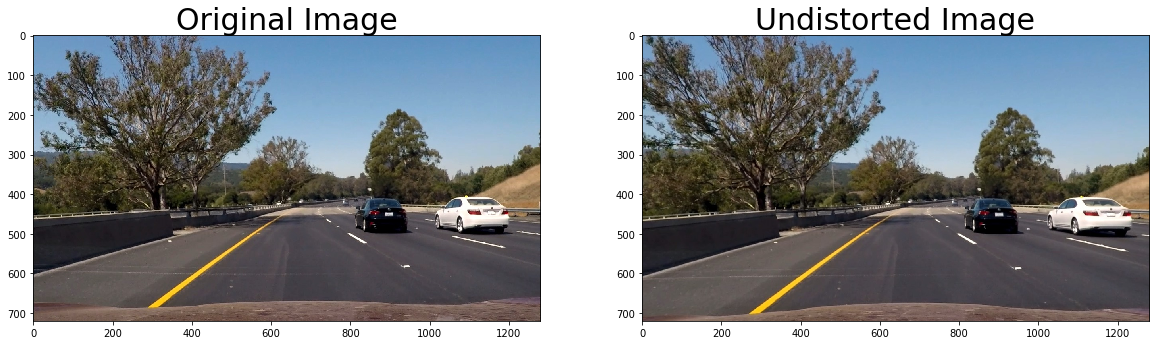

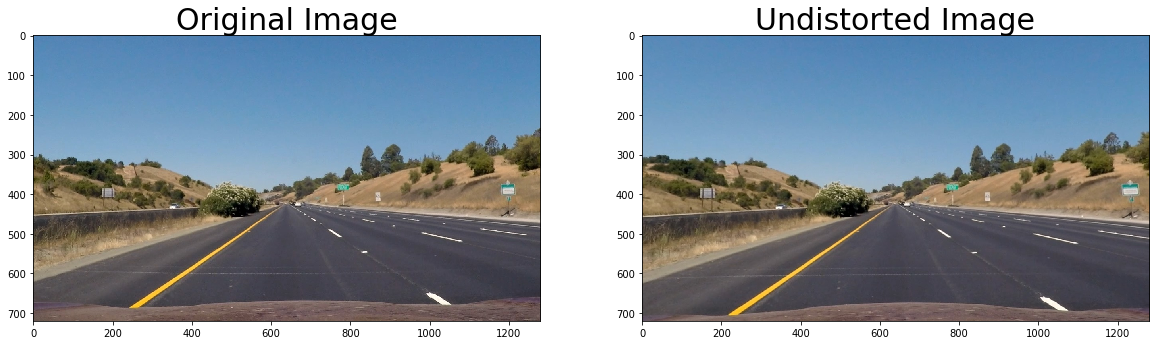

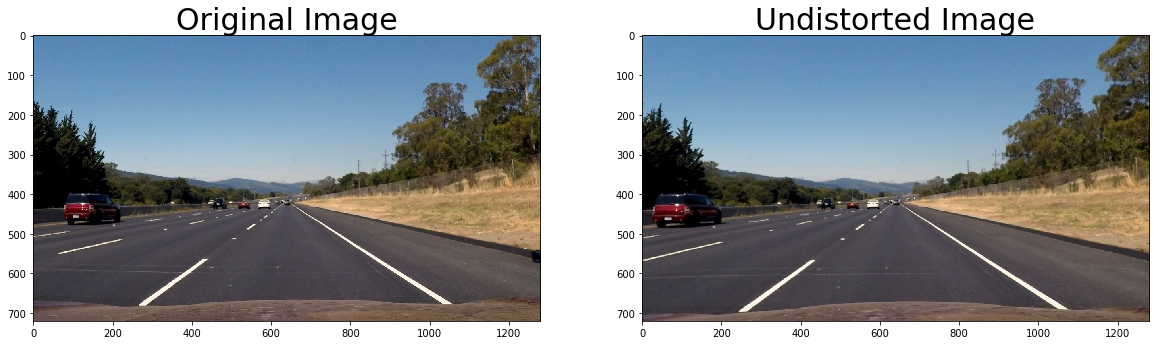

In [6]:
%matplotlib inline

def visualize_undistorted_image(img, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst[:,:,::-1])
    ax2.set_title('Undistorted Image', fontsize=30)    

# Generate undistorted images
images = glob.glob('test_images/test*.jpg')
for img in images:
    dst = cv2.undistort(cv2.imread(img), mtx, dist, None, mtx)
    cv2.imwrite('output_images/undistorted_'+img.split('/')[1], dst)
    visualize_undistorted_image(cv2.imread(img), dst)

images = glob.glob('test_images/straight_lines*.jpg')
for img in images:
    dst = cv2.undistort(cv2.imread(img), mtx, dist, None, mtx)
    cv2.imwrite('output_images/undistorted_'+img.split('/')[1], dst)
    visualize_undistorted_image(cv2.imread(img), dst)

## Use color transforms, gradients, etc., to create a thresholded binary image

In [7]:
def visualize_binary_image(img, dst):
    return
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img[:,:,::-1])
    ax1.set_title('Undistorted Color Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Binary Image', fontsize=30) 

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def binary_pipeline(image, s_thresh=(160, 255), sx_thresh=(20, 120), sobel_kernel=9):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Hue binary
    huebinary = np.zeros_like(h_channel)
    huebinary[(h_channel > 20) & (h_channel < 70)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    final_binary = np.zeros_like(s_channel)
    final_binary[(s_binary == 1) | ((sxbinary == 1) & (huebinary == 1))] = 255
    return final_binary

# Generate binary images
images = glob.glob('output_images/undistorted_test*.jpg')
for img in images:
    color_image = cv2.imread(img)
    binary_image = binary_pipeline(color_image)
    cv2.imwrite('output_images/binary_'+img.split('/')[1], binary_image)
    visualize_binary_image(color_image, binary_image)

images = glob.glob('output_images/undistorted_straight_lines*.jpg')
for img in images:
    color_image = cv2.imread(img)
    binary_image = binary_pipeline(color_image)
    cv2.imwrite('output_images/binary_'+img.split('/')[1], binary_image)
    visualize_binary_image(color_image, binary_image)

## Perspective Transform to birds eye view

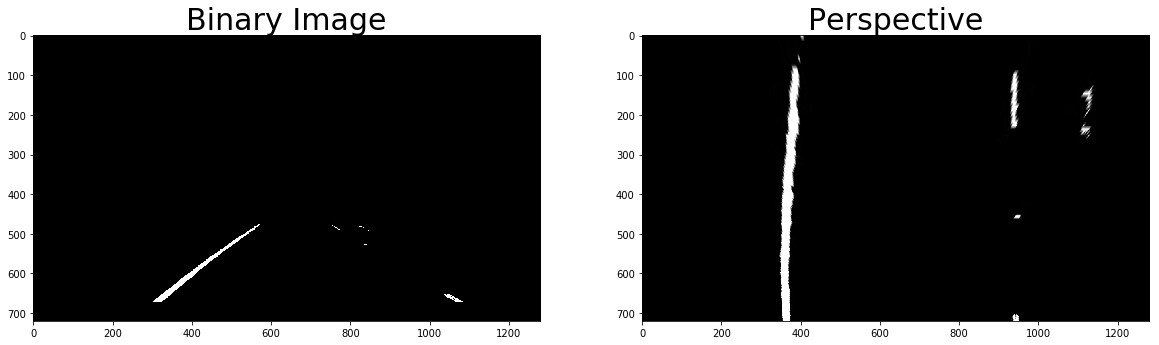

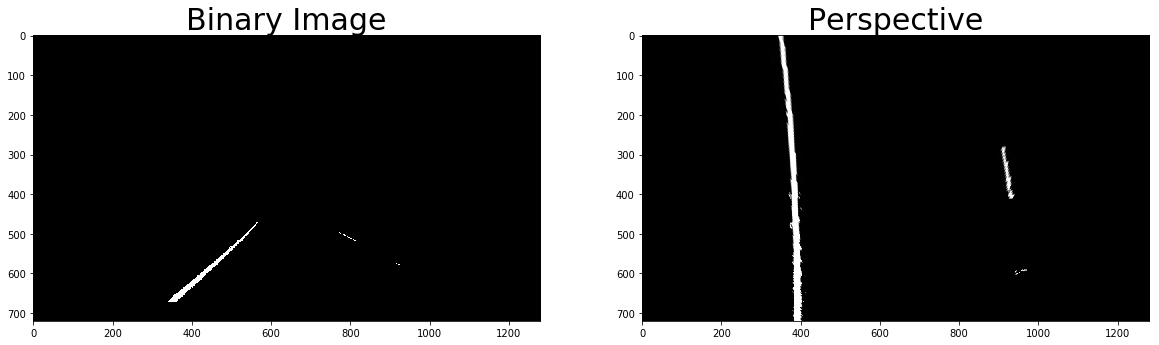

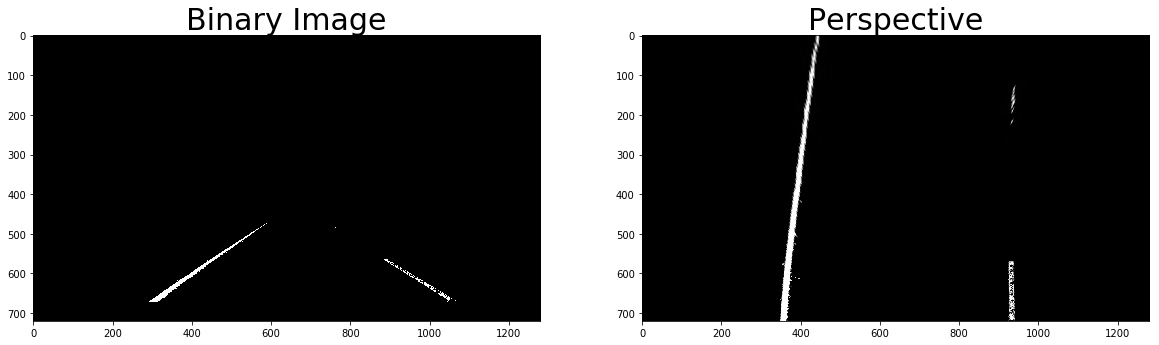

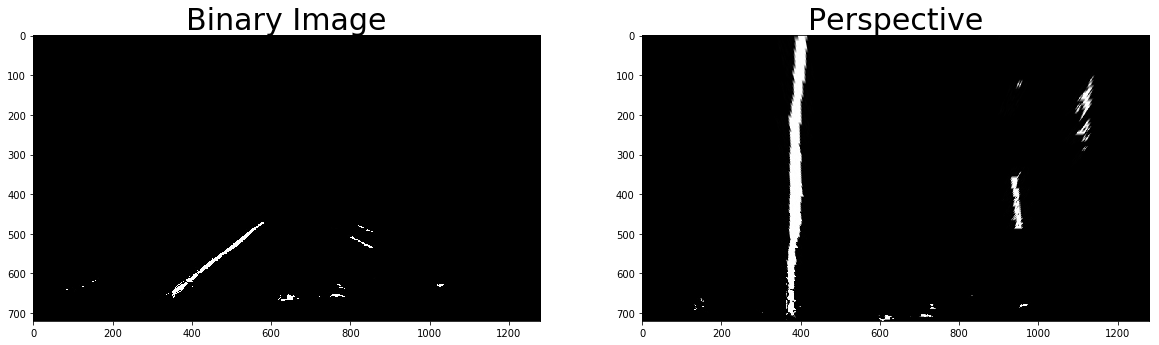

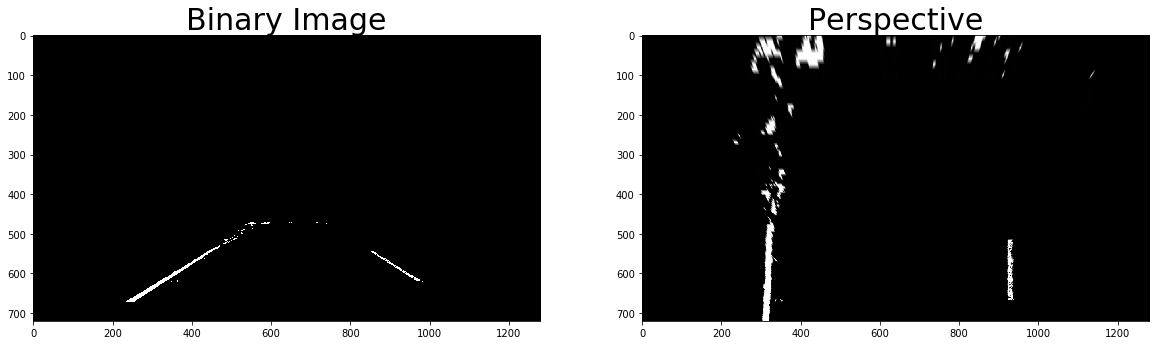

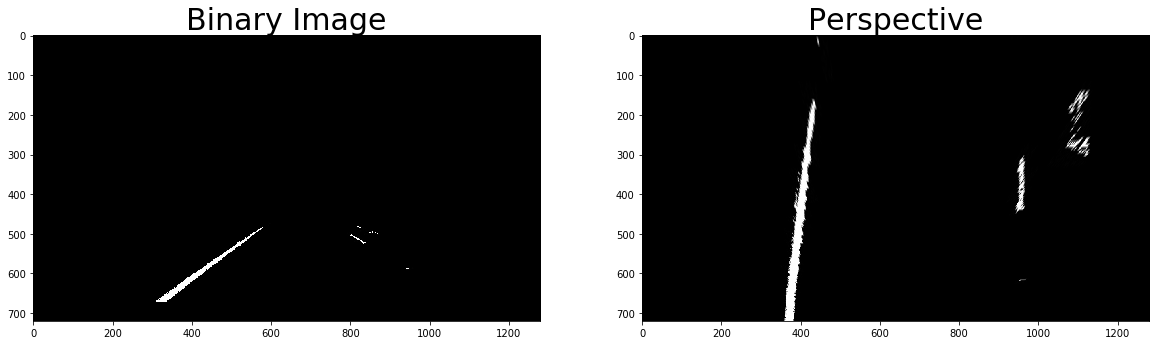

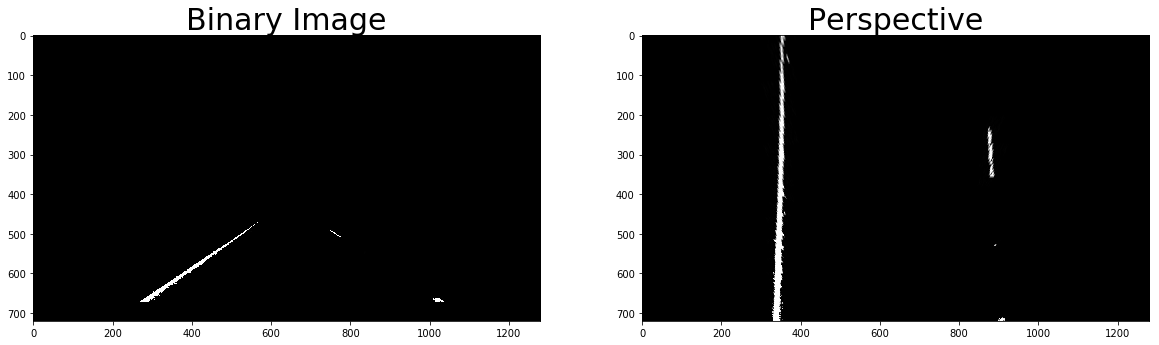

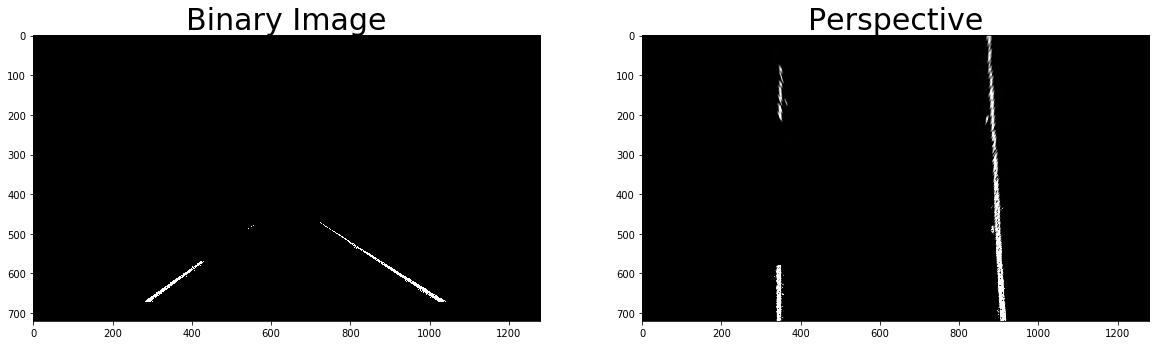

In [63]:
# 1280 * 720 images
# Various perspective transform src, dst pairs tried, last one used.
# src = np.float32(
#                 [ [550, 472],
#                   [800, 472],
#                   [1220, 670],
#                   [200, 670]
#                 ])  

# dst = np.float32(
#                 [ [335, 0],
#                   [1120,0],
#                   [1000, 700],
#                   [315,700 ]
#                 ])

# src = np.float32([[550, 485], [800, 485], [1280, 720], [0, 720]])
# dst = np.float32([[200, 0], [1150,0], [1280, 720], [0, 720]])


src = np.float32(
                [ [550, 471],
                  [800, 471],
                  [1280, 670],
                  [0, 670]
                ])  

dst = np.float32(
                [ [300, 0],
                  [1135,0],
                  [1100, 719],
                  [125,719]
                ])

def visualize_perspective_tf(img, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Binary Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Perspective', fontsize=30) 

def bird_eye_view_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


vertices = np.array([src], dtype=np.int32)  
ignore_mask_color = 255

# Generate bird eye view transform
images = glob.glob('output_images/binary_undistorted_test*.jpg')
for img in images:
    color_image = cv2.imread(img)
    gray_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray_img) 
    gray_mask = cv2.fillPoly(mask, vertices, ignore_mask_color)
    gray = cv2.bitwise_and(gray_img, gray_mask) 
    perspective_tf_img = bird_eye_view_transform(gray, src, dst)
    cv2.imwrite('output_images/tf_'+img.split('/')[1], perspective_tf_img)
    visualize_perspective_tf(gray, perspective_tf_img)
    
images = glob.glob('output_images/binary_undistorted_straight_lines*.jpg')
for img in images:
    color_image = cv2.imread(img)
    gray_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray_img) 
    gray_mask = cv2.fillPoly(mask, vertices, ignore_mask_color)
    gray = cv2.bitwise_and(gray_img, gray_mask) 
    perspective_tf_img = bird_eye_view_transform(gray, src, dst)
    cv2.imwrite('output_images/tf_'+img.split('/')[1], perspective_tf_img)
    visualize_perspective_tf(gray, perspective_tf_img)
    

## Detect lane pixels and fit to find the lane boundary

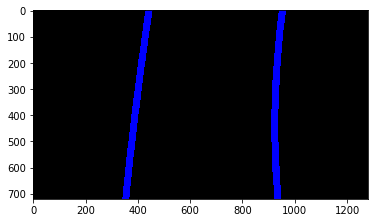

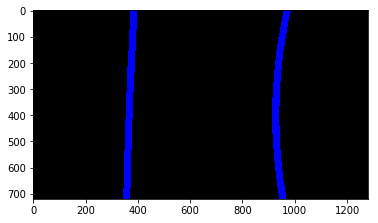

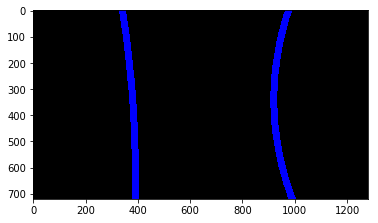

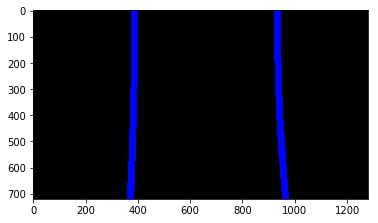

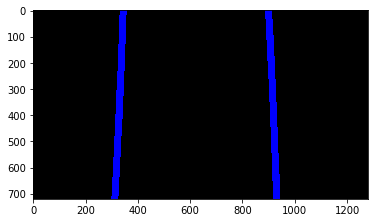

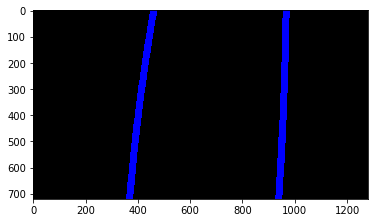

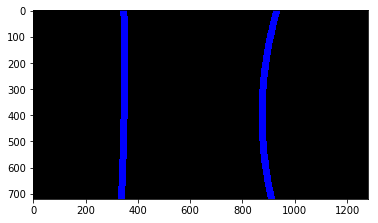

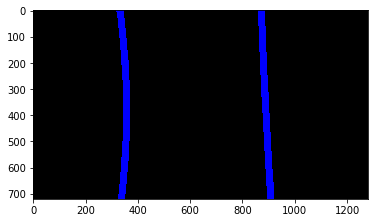

In [68]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    plt.plot(histogram)
#    plt.show()
#    print("bases: ", leftx_base, rightx_base)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 25

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
#        print('leftx_current: ', leftx_current)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #four boundaries of the window
        win_xleft_low = max(leftx_current-margin,0)                      # Update this
        win_xleft_high = min(leftx_current+margin, midpoint)             # Update this
        win_xright_low = max(midpoint, rightx_current-margin)            # Update this
        win_xright_high = min(binary_warped.shape[1], rightx_current+margin) # Update this
        
        # Draw the windows on the visualization image
#        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#        (win_xleft_high,win_y_high),(0,255,0), 2) 
#        cv2.rectangle(out_img,(win_xright_low,win_y_low),
#        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = np.argwhere((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) &
                                     (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) )
        good_right_inds = np.argwhere((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) &
                                      (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) )
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) >= minpix:
            # recenter left window.
            leftx_current += 0.5*(np.mean(nonzerox[np.concatenate(good_left_inds)])-leftx_current)
            leftx_current = np.int(leftx_current)
            
        if len(good_right_inds) >= minpix:
            #recenter right window.
            rightx_current += 0.5*(np.mean(nonzerox[np.concatenate(good_right_inds)])-rightx_current)
            rightx_current = np.int(rightx_current)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Error in Concatenation...')
        exit()

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

#    print('Windows Right: ', win_xright_low, ' : ', win_xright_high)
#    print('Right X: ', rightx)
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):

    # Find our lane pixels first 
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fitting a second order polynomial to each using np.polyfit()
    left_fit = np.polyfit(np.concatenate(lefty), np.concatenate(leftx), 2)
    right_fit = np.polyfit(np.concatenate(righty), np.concatenate(rightx), 2)
    
#    print("Left poly: ", left_fit)
#    print("Right poly: ", right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
#    print('Max Right X2: ', max(rightx))
#    out_img[lefty, leftx] = [255, 0, 0]
#    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
    
    new_img = np.zeros_like(out_img)
    new_points = np.vstack((left_fitx,ploty)).astype(np.int32).T
    cv2.polylines(new_img,  [new_points],  False,  (0, 0, 255),  25)
    
    new_points = np.vstack((right_fitx,ploty)).astype(np.int32).T
    cv2.polylines(new_img,  [new_points],  False,  (0, 0, 255),  25)
    
    return new_img, left_fit, right_fit, left_fitx[-1], right_fitx[-1]

images = glob.glob('output_images/tf_binary_undistorted_test*.jpg')
for img in images:
#    print("File Name: ", img)
    color_image = cv2.imread(img)
    binary_warped = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    out_img, l, r, lx, rx = fit_polynomial(binary_warped)
    cv2.imwrite('output_images/ln_'+img.split('/')[1], out_img)
    plt.imshow(out_img)
    plt.show()

images = glob.glob('output_images/tf_binary_undistorted_straight_lines*.jpg')
for img in images:
#    print("File Name: ", img)
    color_image = cv2.imread(img)
    binary_warped = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    out_img, l, r, lx, rx = fit_polynomial(binary_warped)
    cv2.imwrite('output_images/ln_'+img.split('/')[1], out_img)
    plt.imshow(out_img)
    plt.show()

## Determine lane curvature and vehicle position w.r.t center of the lanes

In [73]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_real(y_eval, left_fit_cr, right_fit_cr):
    '''
    Calculates radius of curvature of left and right lanes and returns the average value.
    '''
    # Default meters per pixel values from the course being used here
    global ym_per_pix
    global xm_per_pix
    #Implementation of the calculation of R_curve (radius of curvature)
    left_curverad =  (1+(2*y_eval*ym_per_pix*left_fit_cr[0]+left_fit_cr[1])**2)**1.5 / (np.absolute(2 * left_fit_cr[0]))
    right_curverad = (1+(2*y_eval*ym_per_pix*right_fit_cr[0]+right_fit_cr[1])**2)**1.5 / (np.absolute(2 * right_fit_cr[0]))    
    return np.around(left_curverad,2), np.around(right_curverad,2)

def measure_vehicle_pos(lx, rx, xmax):
    global ym_per_pix
    global xm_per_pix
    
    center_pos = np.float(xm_per_pix* (xmax/2.0))
    vehicle_pos = np.float(xm_per_pix*((lx+rx)/2.0))
    delta_pos = np.around(np.absolute(center_pos - vehicle_pos), 2)
    msg = "Vehicle is " + str(delta_pos) + "m "
    if (center_pos > vehicle_pos):
        msg += "left of center"
    elif(center_pos < vehicle_pos):
        msg += "right of center"
    else:
        msg += "from center"
    return msg

images = glob.glob('output_images/tf_binary_undistorted_test*.jpg')
for img in images:
    print("File Name: ", img)
    color_image = cv2.imread(img)
    ln_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    out_img, l, r, lx, rx = fit_polynomial(ln_img)
    # Determining radius of curvature at the bottom of the image.
    y_eval = ln_img.shape[0]
#    print ('y_eval: ', y_eval)
    curv = measure_curvature_real(y_eval, l, r)
    print('radius of curvature = ', np.around(np.mean(curv), 0))

images = glob.glob('output_images/tf_binary_undistorted_straight_lines*.jpg')
for img in images:
    print("File Name: ", img)
    color_image = cv2.imread(img)
    ln_img = cv2.cvtColor(color_image,cv2.COLOR_BGR2GRAY)
    out_img, l, r, lx, rx = fit_polynomial(ln_img)
    # Determining radius of curvature at the bottom of the image.
    y_eval = ln_img.shape[0]
#   print ('y_eval: ', y_eval)
    curv = measure_curvature_real(y_eval, l, r)
    print('radius of curvature = ', np.around(np.mean(curv), 0))
    pos_str = measure_vehicle_pos(lx, rx, out_img.shape[1])
    print(pos_str)


File Name:  output_images/tf_binary_undistorted_test3.jpg
radius of curvature =  10076.0
File Name:  output_images/tf_binary_undistorted_test1.jpg
radius of curvature =  11996.0
File Name:  output_images/tf_binary_undistorted_test2.jpg
radius of curvature =  2666.0
File Name:  output_images/tf_binary_undistorted_test4.jpg
radius of curvature =  12631.0
File Name:  output_images/tf_binary_undistorted_test5.jpg
radius of curvature =  35730.0
File Name:  output_images/tf_binary_undistorted_test6.jpg
radius of curvature =  12049.0
File Name:  output_images/tf_binary_undistorted_straight_lines1.jpg
radius of curvature =  5858.0
Vehicle is 0.08m left of center
File Name:  output_images/tf_binary_undistorted_straight_lines2.jpg
radius of curvature =  14995.0
Vehicle is 0.09m left of center


## Warping lane boundries back into image

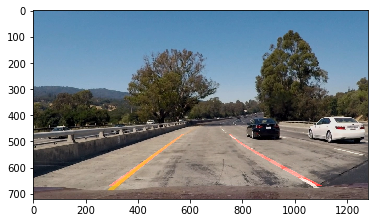

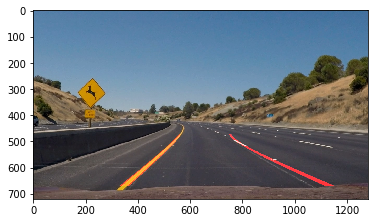

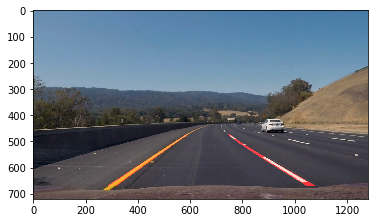

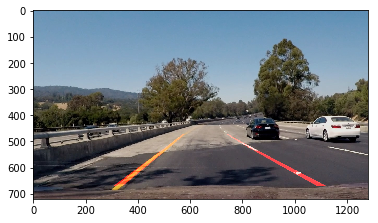

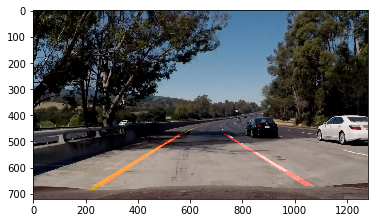

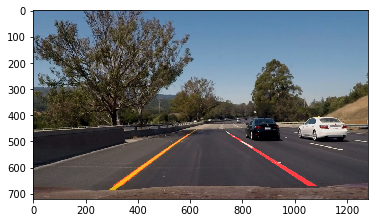

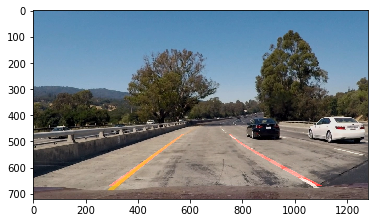

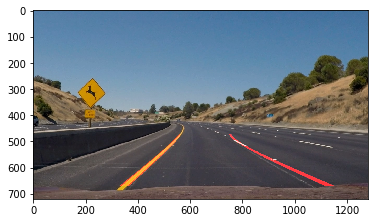

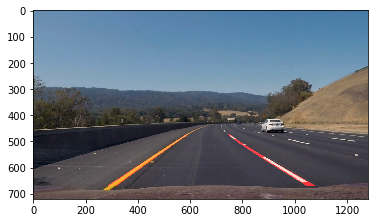

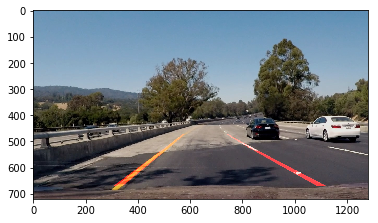

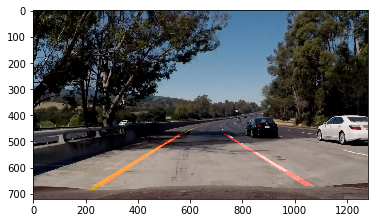

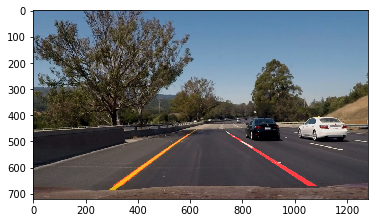

In [74]:
# Generate reverse of bird eye view transform
images = glob.glob('output_images/ln_tf_binary_undistorted_test*.jpg')
for img in images:
    color_image = cv2.imread(img)
    invtf_img = bird_eye_view_transform(color_image, dst, src)
#    visualize_perspective_tf(color_image, invtf_img)
    base_img = img.split('output_images/ln_tf_binary_undistorted_')[1]
    base_color = cv2.imread('test_images/'+base_img)
    final = cv2.addWeighted(invtf_img, 0.8, base_color, 0.9, 0)
    plt.imshow(final[:,:,::-1])  
    plt.show()
    
images = glob.glob('output_images/ln_tf_binary_undistorted_test*.jpg')
for img in images:
    color_image = cv2.imread(img)
    invtf_img = bird_eye_view_transform(color_image, dst, src)
#    visualize_perspective_tf(color_image, invtf_img)
    base_img = img.split('output_images/ln_tf_binary_undistorted_')[1]
    base_color = cv2.imread('test_images/'+base_img)
    final = cv2.addWeighted(invtf_img, 0.8, base_color, 0.9, 0)
    plt.imshow(final[:,:,::-1])  
    plt.show()    

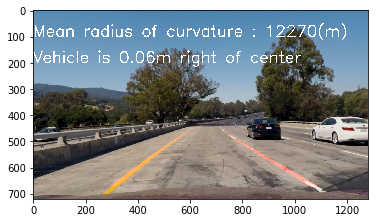

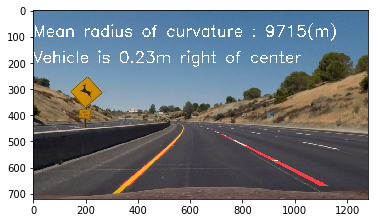

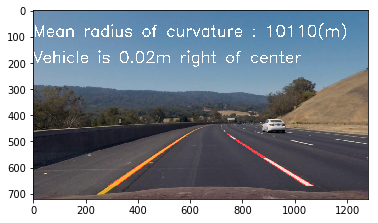

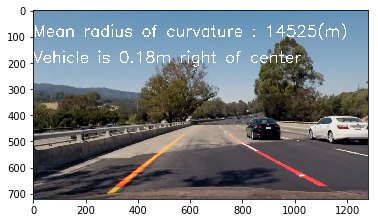

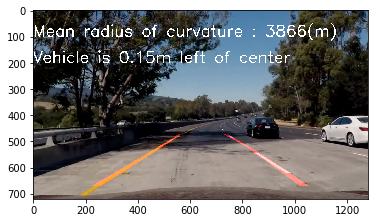

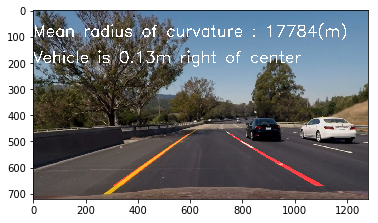

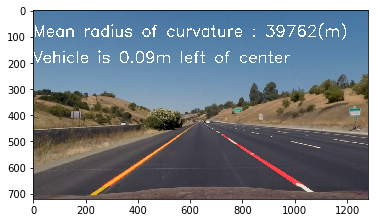

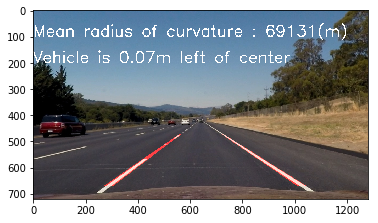

In [77]:
def video_pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary_image = binary_pipeline(undist)
    mask = np.zeros_like(binary_image)
    gray_mask = cv2.fillPoly(mask, vertices, ignore_mask_color)
    gray = cv2.bitwise_and(binary_image, gray_mask) 
    binary_warped = bird_eye_view_transform(gray, src, dst)
    out_img, l, r, lx, rx = fit_polynomial(binary_warped)
    y_eval = binary_warped.shape[0]
    curv = np.int(np.mean(measure_curvature_real(y_eval, l, r)))
    invtf_img = bird_eye_view_transform(out_img, dst, src)
    final = cv2.addWeighted(invtf_img, 0.8, undist, 0.9, 0)
    radius_str = "Mean radius of curvature : " + str(curv) + "(m)"
    cv2.putText(final, radius_str, (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=4)
    pos_str = measure_vehicle_pos(lx, rx, out_img.shape[1])
    cv2.putText(final, pos_str, (0,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=4)
    return final

images = glob.glob('test_images/test*.jpg')
for img in images:
    final_image = video_pipeline(cv2.imread(img))
    plt.imshow(final_image[:,:,::-1])  
    plt.show()

images = glob.glob('test_images/straight_lines*.jpg')
for img in images:
    final_image = video_pipeline(cv2.imread(img))
    plt.imshow(final_image[:,:,::-1])  
    plt.show()